In [1]:
# Load SD
%load_ext autoreload
%autoreload 2
%matplotlib inline

%env CUDA_LAUNCH_BLOCKING=1


env: CUDA_LAUNCH_BLOCKING=1


In [2]:

from lib_prior.diffusion.ctrl_sd_prior import CtrSDPrior

prior = CtrSDPrior()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
# Load optimzied 4D Model

import torch
import os, os.path as osp
import logging
from lib_4d.solver_gs import Solver
from lib_4d.cfg_helpers import OptimCFG, GSControlCFG

from lib_prior.diffusion.sd_sds import StableDiffusionSDS
import numpy as np
from lib_4d.camera import SimpleFovCamerasIndependent
from lib_4d.gs_static_model import StaticGaussian
from lib_4d.gs_ed_model import DynSCFGaussian
from lib_4d.scf4d_model import Scaffold4D
from lib_4d.eval_utils.eval_nvidia import eval_nvidia_dir
import imageio
from omegaconf import OmegaConf
from lib_data.iphone_helpers import load_iphone_gt_poses
from lib_data.nvidia_helpers import load_nvidia_gt_pose, get_nvidia_dummy_test

from lib_4d.solver_viz_helper import viz_curve
from lib_4d.prior2d import Prior2D

from lib_4d.solver_dynamic_funcs import solve_4dscf, grow_node_by_coverage

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
from run import get_cfg

cfg_fn = "./configs/iphone_4x.yaml"
src = "./data/iphone_4x_dev/spin"
dyn_gs_dir = "./data/iphone_4x_dev/spin/log/iphone_4x.yaml20240502_181814" # ! this is the dense long version
device = torch.device("cuda:0")
depth_mode = "gt"
cfg = get_cfg(cfg_fn)

dataset_mode = getattr(cfg, "dataset_mode", "iphone")
max_sph_order = getattr(cfg, "max_sph_order", 1)

In [5]:
solver = Solver(
    src,
    device,
    temporal_diff_shift=getattr(cfg, "temporal_diff_shift", [2, 8]),
    temporal_diff_weight=getattr(cfg, "temporal_diff_weight", [0.6, 0.4]),
    log_prefix="sd_debug_"+osp.basename(cfg_fn),
)
solver.prior2d = Prior2D(
    dino_name="dino_lr",  # ! looks like the LR is better for now
    log_dir=solver.log_dir,
    src_dir=src,
    working_device=device,
    depth_mode=depth_mode,
    min_valid_cnt=1,
    epi_error_th_factor=getattr(cfg, "epi_error_th_factor", 400.0),
    mask_prop_steps=getattr(cfg, "mask_prop_steps", 0),
    use_short_track=getattr(cfg, "use_short_flow", False),
    flow_interval=getattr(cfg, "flow_interval", [1]),
    semantic_th_quantile=getattr(cfg, "semantic_th_quantile", 0.95),
    depth_boundary_th=getattr(cfg, "depth_boundary_th", 0.5),
)

(
    gt_training_cam_T_wi,
    gt_testing_cam_T_wi_list,
    gt_testing_tids_list,
    gt_testing_fns_list,
    gt_training_fov,
    gt_testing_fov_list,
    gt_training_cxcy_ratio,
    gt_testing_cxcy_ratio_list,
) = load_iphone_gt_poses(src, getattr(cfg, "t_subsample", 1))

| DGX-Station | INFO | May-03-13:57:27 | Load flow interval [1]   [prior2d.py:53]
| DGX-Station | INFO | May-03-13:57:27 | Loading motion masks...   [prior2d_utils.py:195]
  0%|          | 0/107 [00:00<?, ?it/s]

100%|██████████| 107/107 [00:00<00:00, 406.03it/s]
| DGX-Station | INFO | May-03-13:57:27 | Loading flows...   [prior2d_utils.py:114]
100%|██████████| 106/106 [00:00<00:00, 215.15it/s]
| DGX-Station | INFO | May-03-13:57:28 | Loading rgbs...   [prior2d_utils.py:98]
100%|██████████| 107/107 [00:00<00:00, 139.37it/s]
| DGX-Station | INFO | May-03-13:57:29 | Loading depths from ./data/iphone_4x_dev/spin/gt_depth ...   [prior2d_utils.py:164]
100%|██████████| 107/107 [00:00<00:00, 151.51it/s]
| DGX-Station | INFO | May-03-13:57:29 | Loading epi-error from ./data/iphone_4x_dev/spin/epipolar_error_npy ...   [prior2d_utils.py:179]
100%|██████████| 107/107 [00:00<00:00, 2638.22it/s]
| DGX-Station | INFO | May-03-13:57:30 | rgbs: (107, 480, 360, 3), depths: (107, 480, 360), flows: [212,(480, 360, 2)], epi_err: (107, 480, 360)   [prior2d_utils.py:82]
| DGX-Station | INFO | May-03-13:57:30 | Normalizing the sensor depth to have median=1 with model depth 0.7018 times of real world depth   [prior2d.

In [6]:
d_model_ckpt = torch.load(osp.join(dyn_gs_dir, "finetune_d_model.pth"))
d_model = DynSCFGaussian.load_from_ckpt(d_model_ckpt, device=device)
# * load static model and camera again, because it's also finetuned
saved_cam = torch.load(osp.join(dyn_gs_dir, "finetune_s_model_cam.pth"))
cams: SimpleFovCamerasIndependent = solver.get_cams(
    fovdeg=float(gt_training_fov),
    gt_pose=gt_training_cam_T_wi,
    gt_fovdeg=float(gt_training_fov),
    cxcy_ratio=gt_training_cxcy_ratio[0],  # gt camera center
)
cams.load_state_dict(saved_cam, strict=True)
s_model = StaticGaussian(
    load_fn=osp.join(dyn_gs_dir, "finetune_s_model.pth"),
    max_sph_order=max_sph_order,
).to(device)

/mnt/essd/leijh/projects/vid24d/lib_4d/scf4d_model.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("skinning_k", torch.tensor(skinning_k).long())
| DGX-Station | INFO | May-03-13:57:39 | Init 4DScaffold with maximum node buffer size: 10000; skinning method: dqb; skinning_k: 10; spatial_unit_meter: 0.05; topo_th_ratio: 8.0; max_sigma: 0.05000000074505806   [scf4d_model.py:90]
| DGX-Station | INFO | May-03-13:57:39 | Set 4D Scaffold with multi-level arap topo reg with level-list=[1, 8], k-list=[16, 8], w-list=[0.4, 0.3]   [scf4d_model.py:205]
| DGX-Station | INFO | May-03-13:57:39 | 4D-Scaffold Summary[1]: T=107; M=6658; K=10; Multi-level=[1, 8]   [scf4d_model.py:142]
| DGX-Station | INFO | May-03-13:57:39 | 4D-Scaffold Summary[2]: curve-dist-K=8; spatial-unit=0.05000000074505806; topo-th-ratio=8.0   [scf4d_model

In [7]:
# test_i = 0
# testing_fov = gt_testing_fov_list[test_i]
# testing_focal = 1.0 / np.tan(np.deg2rad(testing_fov) / 2.0)
# frames = solver.render_test(
#     cams=cams,
#     s_model=s_model,
#     d_model=d_model,
#     train_camera_T_wi=gt_training_cam_T_wi,
#     test_camera_T_wi=gt_testing_cam_T_wi_list[test_i],
#     test_camera_tid=gt_testing_tids_list[test_i],
#     save_dir=osp.join(solver.log_dir, "test"),
#     fn_list=gt_testing_fns_list[test_i],
#     focal=testing_focal,
#     cxcy_ratio=gt_testing_cxcy_ratio_list[test_i],
# )
# imageio.mimsave(osp.join(solver.log_dir, f"test_cam{test_i}.mp4"), frames)

In [11]:
# from lib_4d.campose_alignment import align_ate_c2b_use_a2b
# from lib_4d.render_helper import render
# import matplotlib.pyplot as plt

# test_i = 0
# testing_fov = gt_testing_fov_list[test_i]
# testing_focal = 1.0 / np.tan(np.deg2rad(testing_fov) / 2.0)

# solved_cam_T_wi = torch.stack([cams.T_wc(i) for i in range(cams.T)], 0)
# aligned_test_camera_T_wi = align_ate_c2b_use_a2b(
#     traj_a=gt_training_cam_T_wi,
#     traj_b=solved_cam_T_wi.detach().cpu(),
#     traj_c=gt_testing_cam_T_wi_list[test_i],
# )

# ret = []
# # for _tid in tqdm(range(len(test_camera_tid))):
# _tid = 0
# with torch.no_grad():
#     render_dict = render(
#         # [s_model(), d_model(gt_testing_tids_list[test_i][_tid])],
#         [s_model(active_sph_order=0)],
#         solver.prior2d.H,
#         solver.prior2d.W,
#         cams.rel_focal,
#         cams.cxcy_ratio,
#         T_cw=torch.linalg.inv(aligned_test_camera_T_wi[_tid]).to(device),
#     )
# rgb = render_dict["rgb"].permute(1, 2, 0).detach().cpu().numpy()
# rgb = np.clip(rgb, 0, 1)
# alpha = render_dict["alpha"].squeeze(0).detach().cpu().numpy()

# # plt.imshow(rgb), plt.title("Rendered"), plt.show()
# # plt.imshow(alpha), plt.title("Alpha"), plt.show()

In [ ]:
# # print(rgb.shape)
# # print(alpha.shape)
# import cv2

# img_np = rgb[:360, :360]
# mask = ~(alpha[:360, :360]>0.5)

# target_res = 512

# img_np = cv2.resize(img_np, (target_res, target_res))
# mask = cv2.resize(mask.astype(np.float32), (target_res, target_res)) > 0.5

# # other_mask= (np.random.rand(*mask.shape) < 0.8)
# # other_mask = np.zeros_like(mask)
# # other_mask[:, 180:] = True

# other_mask = np.random.rand(51, 51) < 0.5
# # upsample with nearest
# other_mask = cv2.resize(other_mask.astype(np.float32), (target_res, target_res), interpolation=cv2.INTER_NEAREST) > 0.5
# mask = mask | other_mask 

# inpainted = prior.inpaint(
#     img_np,
#     mask,
#     # "a boy is sitting and spinning",
#     # "clear and beautiful",
#     "a young boy sitting on a large piece of furniture",
#     diff_steps=50,
# )

# plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plt.imshow((~mask)[...,None] * img_np), plt.title("mask")
# plt.subplot(1,3,2)
# plt.imshow(img_np), plt.title("Image")
# plt.subplot(1,3,3)
# plt.imshow(inpainted), plt.title("Inpainted")
# plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([-0.5411, -0.5009, -0.3700,  0.0028,  0.0042,  0.0050, -0.0516, -0.0460,
        -0.0406,  0.0054,  0.0061,  0.0099], device='cuda:0')


| DGX-Station | WARNING | May-03-13:57:58 | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).   [image.py:701]


torch.Size([42523]) tensor(0.3832, device='cuda:0')


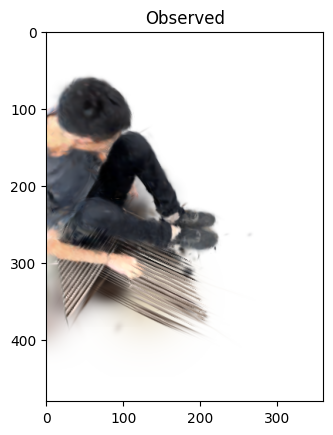

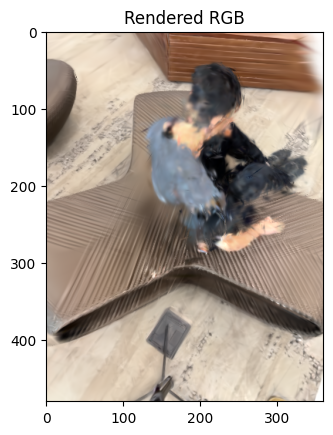

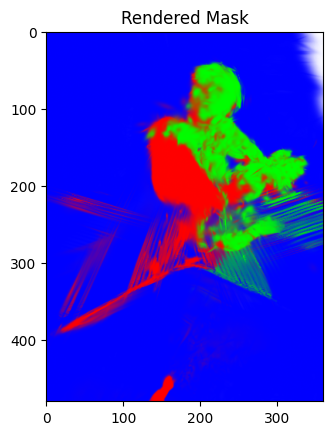

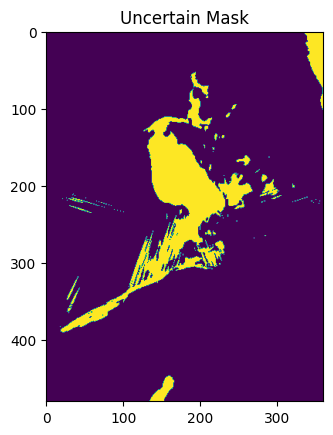

(<matplotlib.image.AxesImage at 0x7f91ed7201f0>,
 Text(0.5, 1.0, 'Uncertain Mask'),
 None)

In [7]:
%matplotlib inline

from pytorch3d.ops import knn_points
from lib_4d.campose_alignment import align_ate_c2b_use_a2b
from lib_4d.render_helper import render, RGB2SH
import matplotlib.pyplot as plt

test_i = 1
testing_fov = gt_testing_fov_list[test_i]
testing_focal = 1.0 / np.tan(np.deg2rad(testing_fov) / 2.0)

solved_cam_T_wi = torch.stack([cams.T_wc(i) for i in range(cams.T)], 0)
aligned_test_camera_T_wi = align_ate_c2b_use_a2b(
    traj_a=gt_training_cam_T_wi,
    traj_b=solved_cam_T_wi.detach().cpu(),
    traj_c=gt_testing_cam_T_wi_list[test_i],
)

ret = []
# for _tid in tqdm(range(len(test_camera_tid))):
_tid = 106
cover_factor=0.3

with torch.no_grad():
    
    d_mu, d_fr, d_s, d_o, d_sph = d_model(_tid)
    s_mu, s_fr, s_s, s_o, s_sph = s_model()
    print(d_sph[0])
    
    render_dict = render(
        [s_model(), (d_mu, d_fr, d_s, d_o, d_sph)],
        solver.prior2d.H,
        solver.prior2d.W,
        cams.rel_focal,
        cams.cxcy_ratio,
        T_cw=torch.linalg.inv(aligned_test_camera_T_wi[0]).to(device),
    )
    
    # make mask
    render_obs_dict = render(
        [(d_mu, d_fr, d_s, d_o, d_sph )],
        solver.prior2d.H,
        solver.prior2d.W,
        cams.rel_focal,
        cams.cxcy_ratio,
        T_cw=cams.T_cw(_tid),
    )
    obs_alpha = render_obs_dict["alpha"].squeeze(0).detach()
    # obs_dep = render_obs_dict["dep"].squeeze(0).detach() /torch.clamp(obs_alpha, min=1e-6)
    obs_dep = render_obs_dict["dep"].squeeze(0).detach()
    
    
    fg_mask = obs_alpha > 0.95
    
    pts_cam = cams.backproject(solver.prior2d.homo_map[fg_mask], obs_dep[fg_mask])
    pts_world = cams.trans_pts_to_world(_tid, pts_cam)
    np.savetxt("./debug/world_dep.xyz", pts_world.detach().cpu().numpy())
    
    
    # identify for all gs pts, which point is visible
    dist_sq, nn_ind, _ = knn_points(d_mu[None], pts_world[None], K=1)
    certain_gs_mask = dist_sq[0,:,0] < (d_model.scf.spatial_unit*cover_factor)**2
    print(certain_gs_mask.shape, certain_gs_mask.float().mean())
    
    # manually 
    certain_color = RGB2SH(torch.tensor([0.0,1.0,0.0])).to(device)
    certain_color = torch.cat([certain_color, torch.zeros(d_sph.shape[1]-3).to(device)])
    free_color = RGB2SH(torch.tensor([1.0,0.0,0.0])).to(device)
    free_color =torch.cat([free_color, torch.zeros(d_sph.shape[1]-3).to(device)])
    bg_color = RGB2SH(torch.tensor([0.0,0.0,1.0])).to(device)
    bg_color =torch.cat([bg_color, torch.zeros(d_sph.shape[1]-3).to(device)])
    d_sph[certain_gs_mask] = certain_color[None]
    d_sph[~certain_gs_mask] = free_color[None]
    
    s_sph[:] = bg_color[None]
    
    render_mask_dict = render(
        [(s_mu, s_fr, s_s, s_o, s_sph), (d_mu, d_fr, d_s, d_o, d_sph)],
        solver.prior2d.H,
        solver.prior2d.W,
        cams.rel_focal,
        cams.cxcy_ratio,
        T_cw=torch.linalg.inv(aligned_test_camera_T_wi[0]).to(device),
    )
    
    

rgb = render_dict["rgb"].permute(1, 2, 0).detach().cpu().numpy()    
rgb = np.clip(rgb, 0, 1)
mask_rgb = render_mask_dict["rgb"].permute(1, 2, 0).detach().cpu().numpy()
mask_rgb = np.clip(mask_rgb, 0, 1)
alpha = render_mask_dict["alpha"].squeeze(0).detach().cpu().numpy()

uncertain_mask = (mask_rgb[...,0] > 0.5) | (alpha < 0.5)

plt.imshow(render_obs_dict["rgb"].permute(1, 2, 0).detach().cpu().numpy()), plt.title("Observed"), plt.show()

plt.imshow(rgb), plt.title("Rendered RGB"), plt.show()
plt.imshow(mask_rgb), plt.title("Rendered Mask"), plt.show()
# plt.imshow(alpha), plt.title("Alpha Mask"), plt.show()
plt.imshow(uncertain_mask), plt.title("Uncertain Mask"), plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

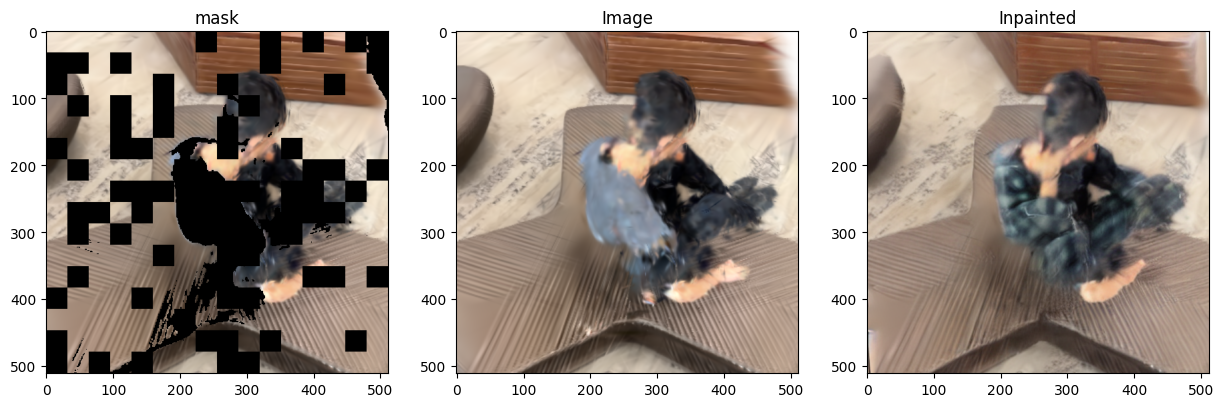

In [19]:
# print(rgb.shape)
# print(alpha.shape)
import cv2

img_np = rgb[:360, :360]
mask = uncertain_mask[:360, :360]

target_res = 512

img_np = cv2.resize(img_np, (target_res, target_res))
mask = cv2.resize(mask.astype(np.float32), (target_res, target_res)) > 0.95

# other_mask= (np.random.rand(*mask.shape) < 0.8)
# other_mask = np.zeros_like(mask)
# other_mask[:, 180:] = True

other_mask = np.random.rand(16, 16) < 0.3
# upsample with nearest
other_mask = cv2.resize(other_mask.astype(np.float32), (target_res, target_res), interpolation=cv2.INTER_NEAREST) > 0.5
mask = mask | other_mask 

inpainted = prior.inpaint(
    img_np,
    mask,
    # "a boy is sitting and spinning",
    # "clear and beautiful",
    "a young boy sitting on a large piece of furniture",
    diff_steps=50,
)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow((~mask)[...,None] * img_np), plt.title("mask")
plt.subplot(1,3,2)
plt.imshow(img_np), plt.title("Image")
plt.subplot(1,3,3)
plt.imshow(inpainted), plt.title("Inpainted")
plt.show()

In [12]:
for i in range(len(gt_testing_cxcy_ratio_list)):
    frames, viz_occ_frames = solver.render_test(
        cams=cams,
        s_model=s_model,
        d_model=d_model,
        train_camera_T_wi=gt_training_cam_T_wi,
        test_camera_T_wi=gt_testing_cam_T_wi_list[i],
        test_camera_tid=gt_testing_tids_list[i],
        save_dir=osp.join(solver.log_dir, "test"),
        fn_list=gt_testing_fns_list[i],
        focal=testing_focal,
        cxcy_ratio=gt_testing_cxcy_ratio_list[i],
    )
    imageio.mimsave(osp.join(solver.log_dir, f"test_cam{i}.mp4"), frames)
    imageio.mimsave(osp.join(solver.log_dir, f"test_cam{i}_occ.mp4"), viz_occ_frames)

100%|██████████| 92/92 [00:34<00:00,  2.67it/s]
[swscaler @ 0x572e900] Warning: data is not aligned! This can lead to a speed loss
[swscaler @ 0x7170900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 89/89 [00:31<00:00,  2.85it/s]
[swscaler @ 0x55fc900] Warning: data is not aligned! This can lead to a speed loss
[swscaler @ 0x581c900] Warning: data is not aligned! This can lead to a speed loss
